In [2]:
from glob import glob
from PIL import Image
from IPython import display
import tensorflow.keras as kr
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os
import pandas as pd

In [24]:
BATCH_SIZE = 128
LATENT_DIM = 100
SAMPLE_INTERVAL = 200
EPOCHS = 1000

In [4]:
def generate_gif(gif_name='mnist_gan.gif', pattern='image*.png'):
    with imageio.get_writer(gif_name, mode='I') as writer:
        filenames = glob(pattern)
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
            
        image = imageio.imread(filename)
        writer.append_data(image)

    # this is a hack to display the gif inside the notebook
    os.system('cp {} {}.png'.format(gif_name, gif_name))

In [5]:
def sample_images(generator, epoch, save=True, name='mnist'):
    """ Sample images from generator, plot them and save as png"""

    noise = np.random.normal(size=(5 * 5, LATENT_DIM))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5     # Rescale images 0-1

    fig, axs = plt.subplots(5, 5)
    c = 0
    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(gen_imgs[c, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            c += 1
            
    if save:
        fig.savefig("{}_{}.png".format(name, epoch))
        plt.close()
    else:
        plt.show()

In [6]:
X = np.load('x_train.npy')
X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')
X = (X - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [7]:
def build_generator(output_shape=(28, 28, 1)): 
    model = kr.Sequential(name='generator')
    
    model.add(kr.layers.Dense(256, input_shape=(LATENT_DIM, )))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(512))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(1024))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(np.prod(output_shape), activation='tanh'))
    model.add(kr.layers.Reshape(output_shape))

    return model


generator = build_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              52

In [8]:
def build_discriminator(input_shape=(28, 28, 1)):
    model = kr.Sequential(name='discriminator')

    model.add(kr.layers.Flatten(input_shape=input_shape))
    model.add(kr.layers.Dense(512))
    model.add(kr.layers.LeakyReLU(alpha=0.2))

    model.add(kr.layers.Dense(256))
    model.add(kr.layers.LeakyReLU(alpha=0.2))

    model.add(kr.layers.Dense(1, activation='sigmoid'))

    return model

In [9]:
discriminator = build_discriminator()
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

In [10]:
optimizer = kr.optimizers.Adam(0.0002, 0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['acc'])
discriminator.trainable = False    # For GAN we will only train the generator

z = kr.Input(shape=(LATENT_DIM,)) 
valid = discriminator(generator(z))

model = kr.Model(z, valid)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         1493520   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [25]:
# Adversarial ground truths
valid_labels = np.ones((BATCH_SIZE, 1))
fake_labels = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    
    # Shuffle and batch data 
    imgs = X[np.random.randint(0, X.shape[0], BATCH_SIZE)] 
    
    loss_real = discriminator.train_on_batch(imgs, valid_labels)
    loss_fake = discriminator.train_on_batch(generator.predict(noise), fake_labels)
    d_loss, d_acc = 0.5 * np.add(loss_real, loss_fake)
    
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    g_loss = model.train_on_batch(noise, valid_labels)
    display.clear_output(wait=True)
    print ("Epoch : %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_acc, g_loss))

    # If at save interval => save generated image samples
    if epoch % SAMPLE_INTERVAL == 0:
        sample_images(generator, epoch, name='y_train.npy')

Epoch : 999 [D loss: 0.603053, acc.: 69.53%] [G loss: 0.994455]


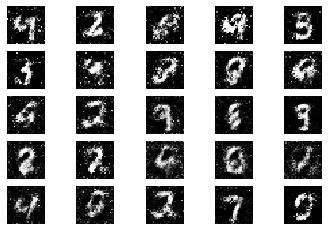

In [26]:
sample_images(generator, None, save=False)

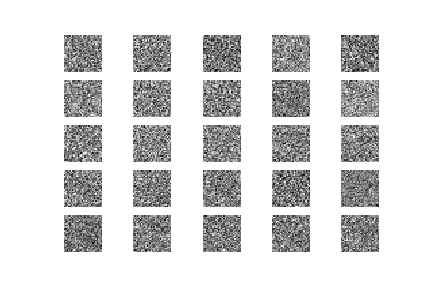

In [23]:
generate_gif(gif_name='y_train.gif', pattern='y_train*.png')
display.Image(filename="y_train.gif.png")

In [44]:
import gzip
f = gzip.open('train-labels-idx1-ubyte.gz','r')

image_size = 28
num_images = 5

import numpy as np
f.read(16)
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)

In [45]:
def generator_model():
    model = kr.Sequential()
    
    model.add(kr.layers.Dense(7 * 7 * 128, activation="relu", input_shape=(LATENT_DIM,)))
    model.add(kr.layers.Reshape((7, 7, 128)))
    
    model.add(kr.layers.UpSampling2D())
    model.add(kr.layers.Conv2D(128, (3, 3), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.ReLU())

    model.add(kr.layers.UpSampling2D())
    model.add(kr.layers.Conv2D(64, (3, 3), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.ReLU())

    model.add(kr.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'))
  
    return model


generator = generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)       0

In [46]:
def discriminator_model():
    model = kr.Sequential()
    
    model.add(kr.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))
      
    model.add(kr.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    # model.add(kr.layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))
    
    model.add(kr.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))
    
    model.add(kr.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))
       
    model.add(kr.layers.Flatten())
    model.add(kr.layers.Dense(1, activation='sigmoid'))
     
    return model


discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)         

In [47]:
optimizer = kr.optimizers.Adam(0.0002, 0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['acc'])
discriminator.trainable = False    # For GAN we will only train the generator

z = kr.Input(shape=(LATENT_DIM,)) 
valid = discriminator(generator(z))

model = kr.Model(z, valid)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         856193    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 390657    
Total params: 1,246,850
Trainable params: 855,809
Non-trainable params: 391,041
_________________________________________________________________


In [52]:
# Adversarial ground truths
valid_labels = np.ones((BATCH_SIZE, 1))
fake_labels = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    
    # Shuffle and batch data 
    imgs = data[np.random.randint(0, data.shape[0], BATCH_SIZE)] 
    
    loss_real = discriminator.train_on_batch(imgs, valid_labels)
    loss_fake = discriminator.train_on_batch(generator.predict(noise), fake_labels)
    d_loss, d_acc = 0.5 * np.add(loss_real, loss_fake)
    
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    g_loss = model.train_on_batch(noise, valid_labels)
    display.clear_output(wait=True)
    print ("Epoch : %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_acc, g_loss))

    # If at save interval => save generated image samples
    if epoch % SAMPLE_INTERVAL == 0:
        sample_images(generator, epoch, name='fashion-mnist_test.csv')

Epoch : 999 [D loss: 0.000118, acc.: 100.00%] [G loss: 4.086452]


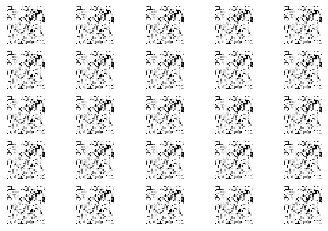

In [57]:
sample_images(generator, None, save=False, name='fashion-mnist_train')

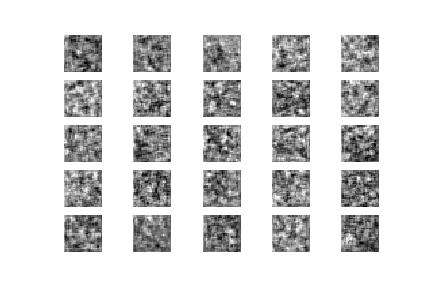

In [54]:
generate_gif(gif_name='fashion-mnist_test.gif', pattern='fashion-mnist_test*.png')
display.Image(filename="fashion-mnist_test.gif.png")
